In [1]:
# STEP 0: Import Libraries
import os, random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# STEP 1: Setup GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/DI_project/MURA-v1.1.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/MURA")

In [5]:
# STEP 2: Define Custom Dataset
class MURADataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

    def __len__(self):
        return len(self.image_paths)


In [6]:
# STEP 3: Data Transforms (Prétraitement)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                 # Standard image size for CNNs
    transforms.RandomHorizontalFlip(),             # Data augmentation
    transforms.RandomRotation(10),                 # Data augmentation
    transforms.ToTensor(),                         # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406],     # ImageNet mean
                         [0.229, 0.224, 0.225])     # ImageNet std
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [7]:
# STEP 4: Load Image Paths and Labels
def get_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.png'):
                full_path = os.path.join(root, file)
                label = 1 if "positive" in full_path.lower() else 0
                image_paths.append(full_path)
                labels.append(label)
    return image_paths, labels

# 🔁 Adjust path if needed
image_paths, labels = get_image_paths_and_labels("/content/MURA/MURA-v1.1/train")
print("Total images:", len(image_paths))


Total images: 36808


In [8]:
# STEP 5: Split + Load Data
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42)

train_dataset = MURADataset(train_paths, train_labels, train_transform)
test_dataset = MURADataset(test_paths, test_labels, test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [9]:
# STEP 6: Load Model (ResNet50)
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


In [10]:
# STEP 7: Weighted Loss + Optimizer
class_counts = torch.tensor([train_labels.count(0), train_labels.count(1)], dtype=torch.float)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [11]:
# STEP 8: Train the Model
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.2f}, Accuracy: {acc:.2f}%")
        torch.save(model.state_dict(), f"/content/drive/MyDrive/DI_project/resnet50_epoch{epoch+1}.pth")


In [12]:
# STEP 9: Evaluate the Model
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=["Normal", "Abnormal"]))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [13]:
# STEP 10: Predict Random Images
def test_random_images(model, image_paths, labels, device, num_samples=10):
    model.eval()
    samples = random.sample(list(zip(image_paths, labels)), num_samples)
    label_map = {0: "Normal", 1: "Abnormal"}

    for image_path, true_label in samples:
        image = Image.open(image_path).convert("RGB")
        input_tensor = test_transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Predicted: {label_map[pred.item()]} | True: {label_map[true_label]}")
        plt.show()


In [17]:
# Train (15 epochs for best balance)
train_model(model, train_loader, criterion, optimizer, device, epochs=15)


Epoch 1/15, Loss: 369.55, Accuracy: 83.02%
Epoch 2/15, Loss: 354.02, Accuracy: 83.77%
Epoch 3/15, Loss: 337.15, Accuracy: 84.88%
Epoch 4/15, Loss: 318.45, Accuracy: 85.73%
Epoch 5/15, Loss: 302.71, Accuracy: 86.50%
Epoch 6/15, Loss: 284.25, Accuracy: 87.41%
Epoch 7/15, Loss: 267.13, Accuracy: 88.32%
Epoch 8/15, Loss: 249.39, Accuracy: 88.94%
Epoch 9/15, Loss: 228.70, Accuracy: 90.09%
Epoch 10/15, Loss: 213.96, Accuracy: 90.72%
Epoch 11/15, Loss: 201.40, Accuracy: 91.20%
Epoch 12/15, Loss: 181.19, Accuracy: 92.25%
Epoch 13/15, Loss: 171.45, Accuracy: 92.70%
Epoch 14/15, Loss: 156.22, Accuracy: 93.32%
Epoch 15/15, Loss: 149.95, Accuracy: 93.66%


              precision    recall  f1-score   support

      Normal       0.85      0.77      0.80      4380
    Abnormal       0.70      0.80      0.74      2982

    accuracy                           0.78      7362
   macro avg       0.77      0.78      0.77      7362
weighted avg       0.79      0.78      0.78      7362



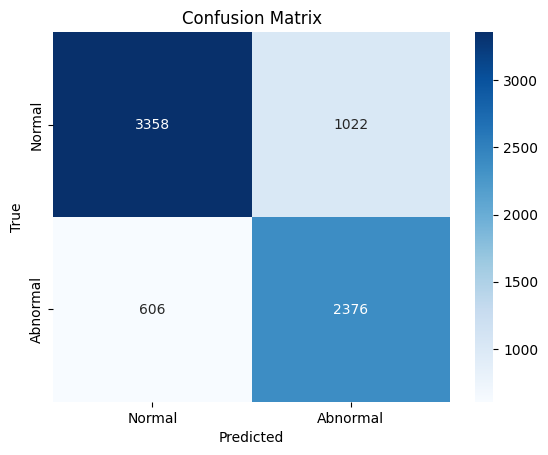

In [18]:
evaluate_model(model, test_loader, device)


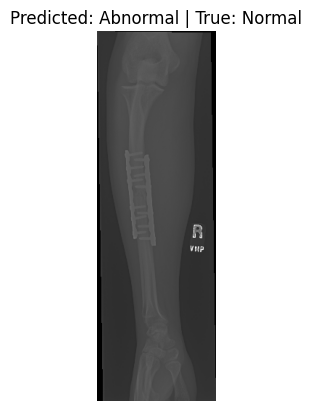

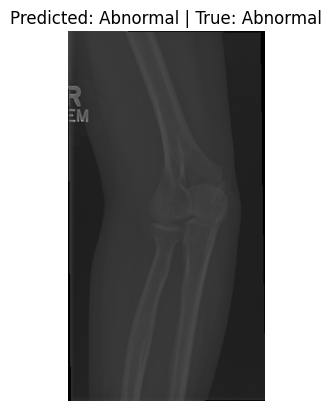

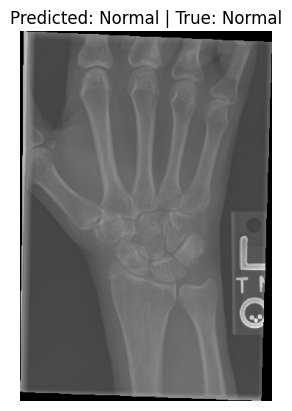

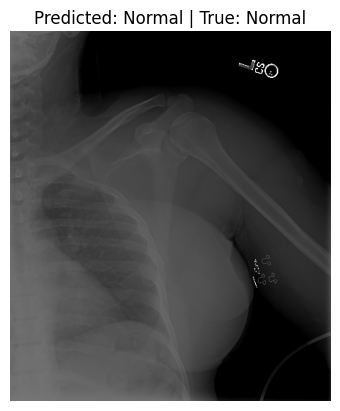

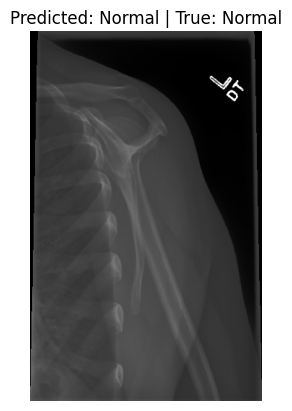

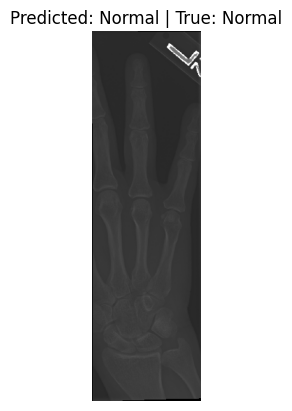

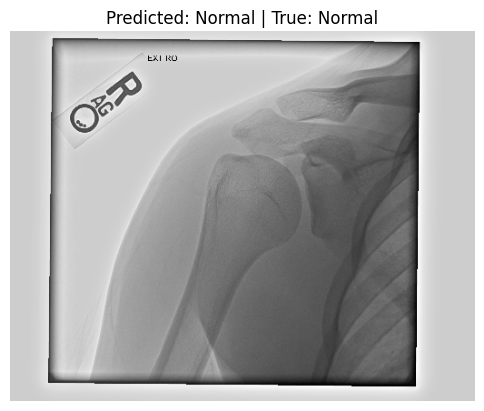

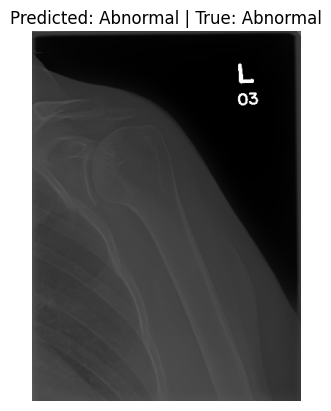

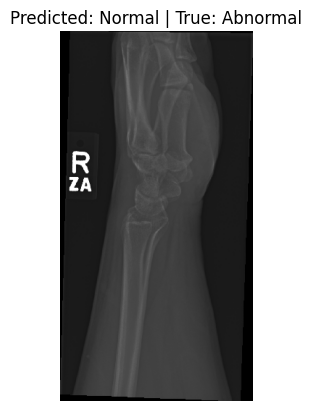

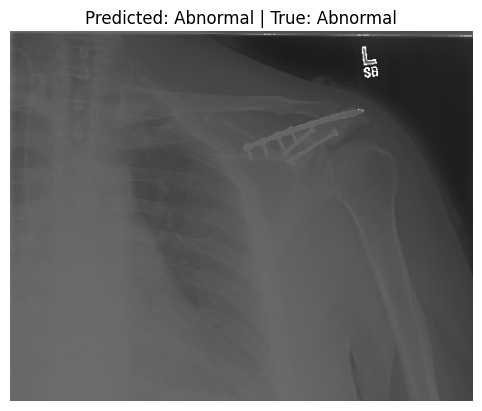

In [19]:
test_random_images(model, test_paths, test_labels, device)


In [30]:
def predict_image(path, model, device):
    model.eval()
    image = Image.open(path).convert('RGB')

    # Enhance contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2.0)

    # Show image
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Preprocess and predict
    image_tensor = test_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        label = predicted.item()

    result = "Abnormal" if label == 1 else "Normal"
    print(f"Prediction: {result}")


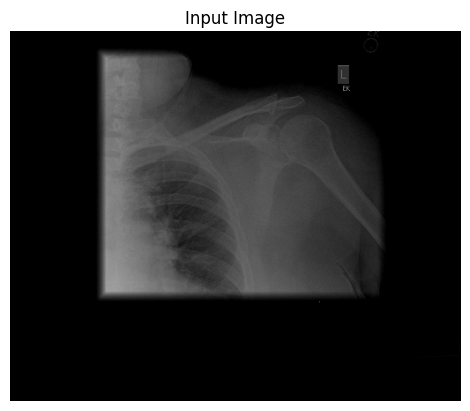

Prediction: Normal


In [32]:
from PIL import ImageEnhance
model.load_state_dict(torch.load("/content/drive/MyDrive/DI_project/resnet50_epoch15.pth"))
model = model.to(device)

# Predict
predict_image("/content/MURA/MURA-v1.1/valid/XR_SHOULDER/patient11187/study1_negative/image3.png", model, device)


In [22]:
import os

def get_some_image_paths(base_dir, num=5):
    count = 0
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".png"):
                print(os.path.join(root, file))
                count += 1
                if count >= num:
                    return

get_some_image_paths("/content/MURA/MURA-v1.1/valid")


/content/MURA/MURA-v1.1/valid/XR_SHOULDER/patient11758/study1_negative/image3.png
/content/MURA/MURA-v1.1/valid/XR_SHOULDER/patient11758/study1_negative/image4.png
/content/MURA/MURA-v1.1/valid/XR_SHOULDER/patient11758/study1_negative/image1.png
/content/MURA/MURA-v1.1/valid/XR_SHOULDER/patient11758/study1_negative/image2.png
/content/MURA/MURA-v1.1/valid/XR_SHOULDER/patient11187/study1_negative/image3.png
